## TADKit - CAD, Conformal Anomaly Detection demonstrator

This notebook demonstrates how to implement the CAD framework by combining TADkit learners with the PUNCC library.

NB: note that the focus is on technical inter-operability, not functional results.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# we start by creating synthetic data split in three (train, calib and test) for CAD purposes
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pandas as pd

from tadkit.utils.synthetic_ornstein_uhlenbeck import synthetise_ornstein_uhlenbeck_data

data, ground_truth = synthetise_ornstein_uhlenbeck_data(n_rows=10000, n_cols_x=20)

from tadkit.catalog.formalizers import PandasFormalizer
formalizer = PandasFormalizer(data_df=data, dataframe_type="synchronous")
results = {}

# set train & calib limits
base_query = formalizer.default_query()
cut1, cut2 = data.index[data.shape[0]//3], data.index[2*data.shape[0]//3]

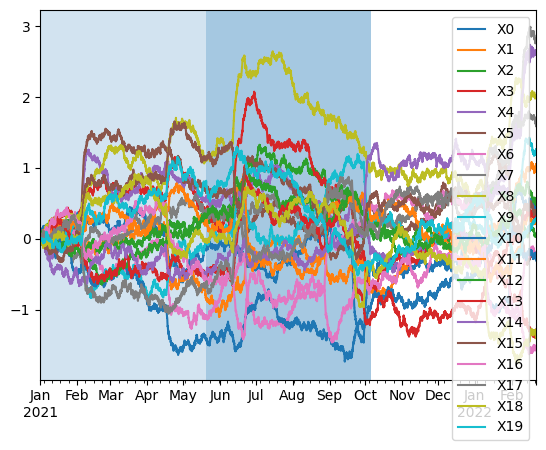

In [2]:
# multivariate data
X = formalizer.formalize(**base_query)
base_query["target_period"] = (base_query["target_period"][0], cut1)
X_train = formalizer.formalize(**base_query)
y_train = ground_truth.loc[:cut1]
base_query["target_period"] = (cut1, cut2)
X_calib = formalizer.formalize(**base_query)
y_calib = ground_truth.loc[cut1:cut2]

# univariate data
base_query = formalizer.default_query()
base_query["target_space"] = ["X1"]
x = formalizer.formalize(**base_query)
base_query["target_period"] = (base_query["target_period"][0], cut1)
x_train = formalizer.formalize(**base_query)
base_query["target_period"] = (cut1, cut2)
x_calib = formalizer.formalize(**base_query)

ax = X.plot()
ax.axvspan(X_train.index[0], X_train.index[-1], alpha=0.2)
ax.axvspan(X_calib.index[0], X_calib.index[-1], alpha=0.4)
plt.show()

In [3]:
# select methods that are compatible with these data
from tadkit.catalog.learners import installed_learner_classes
installed_learner_classes

[09-04 16:13:37] {C:\Users\martin.royer\SVN\tdaad\tdaad\twe_logger.py:104} INFO - Logger: name: twe_logger, handlers: [<StreamHandler stdout (DEBUG)>]
[09-04 16:13:37] {C:\Users\martin.royer\SVN\tdaad\tdaad\twe_logger.py:104} INFO - Logger: name: twe_logger, handlers: [<StreamHandler stdout (DEBUG)>]
[TADKit-Catalog]
Class learner_name='cnndrad' is registered in TADKit.
cnndrad is operational in this environment.
cnndrad is implicit child of TADLearner.
Class learner_name='sbad' is registered in TADKit.
sbad returns err=ModuleNotFoundError("No module named 'sbad_fnn'").
Class learner_name='kcpd' is registered in TADKit.
kcpd is operational in this environment.
kcpd is implicit child of TADLearner.
Class learner_name='tdaad' is registered in TADKit.
tdaad is operational in this environment.
tdaad is implicit child of TADLearner.
Class learner_name='isolation-forest' is registered in TADKit.
isolation-forest is operational in this environment.
isolation-forest is implicit child of TADLea

{'cnndrad': cnndrad.detector.DataReconstructionAD,
 'kcpd': kcpdi.kcp_ss_learner.KcpLearner,
 'tdaad': tdaad.anomaly_detectors.TopologicalAnomalyDetector,
 'isolation-forest': sklearn.ensemble._iforest.IsolationForest,
 'kernel-density': sklearn.neighbors._kde.KernelDensity,
 'scaled-kernel-density': tadkit.catalog.learners._sklearn_learners.ScaledKernelDensityLearner}

In [4]:
# puncc imports and wrapper
from deel.puncc.anomaly_detection import SplitCAD
from deel.puncc.api.prediction import BasePredictor
# The nonconformity scores are defined as the IF scores (anomaly score).
# By default, score_samples return the opposite of IF scores.
# We need to redefine the predict to output the nonconformity scores.
class ADPredictor(BasePredictor):
    def predict(self, X):
        return -self.model.score_samples(X)
        
# We set the maximum false detection rate to 1%
alpha = 0.05

Epoch 1/100
81/81 [==============================] - 15s 55ms/step - loss: 0.1629 - mae: 0.2731 - val_loss: 2.8096 - val_mae: 1.6441
Epoch 2/100
81/81 [==============================] - 2s 29ms/step - loss: 0.0766 - mae: 0.1697 - val_loss: 2.8074 - val_mae: 1.6425
Epoch 3/100
81/81 [==============================] - 2s 28ms/step - loss: 0.0635 - mae: 0.1491 - val_loss: 2.7961 - val_mae: 1.6388
Epoch 4/100
81/81 [==============================] - 2s 26ms/step - loss: 0.0577 - mae: 0.1387 - val_loss: 2.7611 - val_mae: 1.6272
Epoch 5/100
81/81 [==============================] - 3s 33ms/step - loss: 0.0546 - mae: 0.1330 - val_loss: 2.6363 - val_mae: 1.5901
Epoch 6/100
81/81 [==============================] - 2s 31ms/step - loss: 0.0515 - mae: 0.1269 - val_loss: 2.5815 - val_mae: 1.5730
Epoch 7/100
81/81 [==============================] - 3s 31ms/step - loss: 0.0499 - mae: 0.1252 - val_loss: 2.5922 - val_mae: 1.5742
Epoch 8/100
81/81 [==============================] - 3s 31ms/step - loss: 0

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

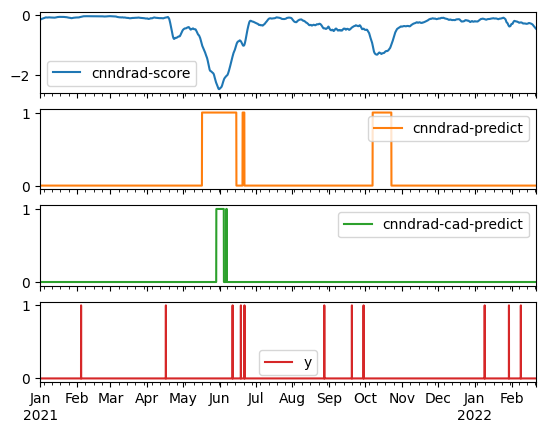

In [5]:
name = "cnndrad"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=x.index)
learner = learner_class().fit(x_train)
results[name][f"{name}-score"] = learner.score_samples(x)
results[name][f"{name}-predict"] = 1-(learner.predict(x)+1)//2

if_predictor = ADPredictor(learner_class())
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=x_train, z_calib=x_calib)

# The method `predict` is calledµ on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(x, alpha=alpha).astype(int)

pd.concat([results[name], ground_truth], axis=1).plot(subplots=True)

In [ ]:
name = "kcpd"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=X.index)
learner = learner_class().fit(X_train)
results[name][f"{name}-score"] = learner.score_samples(X)
results[name][f"{name}-predict"] = 1-(learner.predict(X)+1)//2

if_predictor = ADPredictor(learner_class())
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=X_train, z_calib=X_calib)

# The method `predict` is called on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(X, alpha=alpha).astype(int)

pd.concat([results[name], ground_truth], axis=1).plot(subplots=True)

In [ ]:
name = "tdaad"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=X.index)
learner = learner_class(tda_max_dim=1).fit(X_train)
results[name][f"{name}-score"] = learner.score_samples(X)
results[name][f"{name}-predict"] = 1-(learner.predict(X)+1)//2

if_predictor = ADPredictor(learner_class(tda_max_dim=1))
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=X_train, z_calib=X_calib)

# The method `predict` is called on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(X, alpha=alpha).astype(int)

pd.concat([results[name], y], axis=1).plot(subplots=True)

In [ ]:
name = "isolation-forest"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=X.index)
learner = learner_class().fit(X_train)
results[name][f"{name}-score"] = learner.score_samples(X)
results[name][f"{name}-predict"] = 1-(learner.predict(X)+1)//2

if_predictor = ADPredictor(learner_class())
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=X_train, z_calib=X_calib)

# The method `predict` is called on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(X, alpha=alpha).astype(int)

pd.concat([results[name], ground_truth], axis=1).plot(subplots=True)

In [ ]:
name = "kernel-density"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=X.index)
learner = learner_class().fit(X_train)
results[name][f"{name}-score"] = learner.score_samples(X)
results[name][f"{name}-predict"] = 1-(learner.predict(X)+1)//2

if_predictor = ADPredictor(learner_class())
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=X_train, z_calib=X_calib)

# The method `predict` is called on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(X, alpha=alpha).astype(int)

pd.concat([results[name], ground_truth], axis=1).plot(subplots=True)

In [ ]:
name = "scaled-kernel-density"
learner_class = installed_learner_classes[name]

results[name] = pd.DataFrame(index=X.index)
learner = learner_class().fit(X_train)
results[name][f"{name}-score"] = learner.score_samples(X)
results[name][f"{name}-predict"] = 1-(learner.predict(X)+1)//2

if_predictor = ADPredictor(learner_class())
# Instantiate CAD on top of IF predictor
if_cad = SplitCAD(if_predictor, train=True, random_state=0)

if_cad.fit(z_fit=X_train, z_calib=X_calib)

# The method `predict` is called on the new data points
# to test which are anomalous and which are not
results[name][f"{name}-cad-predict"] = if_cad.predict(X, alpha=alpha).astype(int)

pd.concat([results[name], ground_truth], axis=1).plot(subplots=True)